# Federated Machine Learning in PyTorch

This notebook is a demonstration of _federated learning_, an approach to training a machine learning model by combining the results of training local models on multiple devices.

This notebook is part of a series intended to start from the basics to demonstrate federated learning in `pytorch`, then move on to test some of the bounds of what federated learning can (and can't) do.

## The Task: Digit Recognition

For this demonstration, our task is a classic one: the MNIST digit recognition task. Specifically, we need to determine which number is written in an image of a handwritten digit like this one: 

![Handwritten digit "6"](images/example-6.png)

To carry out this task we need a machine learning model to "look" at an image and classify it into a number. We also need and image data to train the model. We're going to use a simple convolutional neural network model. For the training images, we're using the well-known MNIST digits dataset.

## The Approach: Federation

The federated approach uses several _worker_ devices to train their own local models with independent data. That is, the workers each train their own local model with a subset of the full dataset.

Each worker trains its local model for a bit, then sends its incrementally trained local model back to a _manager_. The manager combines the local models from all of the workers into a master model, then sends the master model back to the workers. This process is called a _round_. 

Then another round begins: the workers each train their local copy of the master model (creating another set of individualized local models), send those local models back to the manager. Once again the manager combines these individualized local models into a new master model, and pushes the new master model down to the workers. This cycle of rounds repeats as long as is necessary and useful.

## Our Federation Library

The `federated` library we're using here is a *simulation* of a federated network. It's not *true* federated learning because it uses one machine to simulate several indepedent machines. This means it does not have to deal with network communication or the timing problems inherent to parallelism. But the "local" models are independent and that is sufficient to demonstrate the principles underlying federated learning.

Our library includes a `FederatedManager` class and a `FederatedWorker` class. A `FederatedManager` contains a master prediction model and creates several independent `FederatedWorker` instances. Each `FederatedWorker` has its own local model and a distinct subset of the MNIST data.

In each `round` of federated learning, each `FederatedWorker` trains its local model using only the data that that worker recieves, and then sends its trained local model to the `FederatedManager`. The `FederatedManager` combines the models into an updated master model and pushes that new master model down to each `FederatedWorker`. There are a number of algorithms available for combining local models. Our library uses [federated averaging](https://arxiv.org/abs/1602.05629), a very simple element-by-element average of the model's weights.

We're going to see how federation works and test out some corner cases here. Let's get started with the code.

## The Model

Now we define the model. We're using the [sample model from the `pytorch` package](https://github.com/pytorch/examples/blob/master/mnist/main.py).

In [1]:
# Define the model

import torch.nn as nn
import torch.nn.functional as F

'''   

# THIS IS THE OFFICIAL PYTORCH EXAMPLE, BUT IT'S SLOWER THAN THE OTHER MODEL, SO FOR NOW, IT'S FAST BEFORE TIDY

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
'''

# Quick and gets the job done well enough for testing
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
#'''

## The Data - Standard MNIST Datasets
Here we get plain vanilla MNIST data, a training set and a test set, from the `pytorch` package, again using the same transforms as their example.

If you don't already have the MNIST data on your machine, the setting `download=True` in the call to `torchvision.datasets.MNIST()` will fetch it for you.

In [2]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

# create standard datasets using all of the MNIST data
data_path = './MNIST-data/raw'

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dset = dsets.MNIST(root=data_path, download=True, train=True, transform=trans)
test_dset = dsets.MNIST(root=data_path, download=True, train=False, transform=trans)

Now we have our standard MNIST `Dataset`s: `train_dset` contains 60,000 examples, and `test_dset` contains 10,000 samples.

In [3]:
print("Train dataset size: ", len(train_dset))
print("Test dataset size : ", len(test_dset))

Train dataset size:  60000
Test dataset size :  10000


Pytorch uses `DataLoader`s for training. A `DataLoader` contains a `Dataset` and training parameters like `batch_size`.

In [4]:
from torch.utils.data import DataLoader

train_batch_size = 64
test_batch_size = 1000

# create standard dataloaders using all of the MNIST data
train_dl = DataLoader(train_dset, batch_size=train_batch_size, shuffle=True)
test_dl = DataLoader(test_dset, batch_size=test_batch_size, shuffle=True)

Let's check out the default data. The out-of-the-box MNIST dataset has roughly equal numbers of samples for each digit, i.e., about as many samples of `4`s as `6`s (though the set is a *little* heavy on `1`s and a *little* light on `5`s).

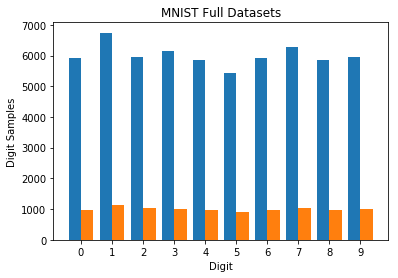

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tqdm.notebook import trange
import federated as fed
import federated_mnist as fm
from collections import Counter
import numpy as np

'''
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Standard MNIST Digit Counts')
ax.set_xlabel('Digit')
ax.set_ylabel('Digit Samples')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.hist([train_dl.dataset.targets.tolist(), test_dl.dataset.targets.tolist()*6], 
        label=['Train', 'Test (scaled)'],
        bins=list(range(11)), 
        histtype='bar',
        align='left',
        rwidth=0.8,
       )
ax.legend();
'''

def plot_digit_histogram(dls, title=''):

    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.set_ylabel('Digit Samples')
    ax.set_xlabel('Digit')
    
    ys = []
    for dset in tqdm([dl.dataset for dl in dls], desc='Tabulating datasets'):
        _, y = fm.consume_dataset(dset)
        ys.append(sorted(Counter(y)))
        
    H = ax.hist(ys, bins=range(11), histtype='bar', align='left', rwidth=0.8)


plot_digit_histogram([train_dl, test_dl], 'MNIST Full Datasets')

The training data is reasonably well distributed, and the plots above confirm it. The test set counts are smaller by a factor of six, which reflects the relative sizes of the train and test datasets.

## Baseline: The Non-Federated Approach

To show a baseline of non-federated learning, we train a model the traditional way, i.e., using just one worker. (Technically we're using the federated library, but with one worker that's equivalent to non-federated learning.) This one worker will train on the full standard MNIST dataset of 60,000 examples.

In [6]:
print("Dataset size: ", len(train_dl.dataset))

Dataset size:  60000


In [7]:
# MOVE TO LIBRARY?

default_n_rounds = 100
default_target_acc = 95.0

def make_manager(name,
                 train_dls, 
                 test_dset, 
                 model=Net, 
                 verbose=False,
                 lr=1e-2,
                 n_epochs=1,
                ):
    
    if not isinstance(train_dls, list):
        train_dls = [train_dls]
        
    return fed.FederatedManager(train_dls, model, test_dset, n_epochs=n_epochs, lr=lr, verbose=verbose, name=name)

def run_manager(mgr, n_rounds, target_acc=None):
    
    target_met = False;
    
    if (target_acc):
        print('{} manager training with {} worker(s) for up to {} rounds or {:.2%} accuracy.'.format(
                mgr.name,
                mgr.n_workers,
                n_rounds,
                target_acc / 100,))
    else:
        print('{} manager training with {} worker(s) for {} rounds.'.format(
                mgr.name,
                mgr.n_workers,
                n_rounds,))

    for i in trange(n_rounds, desc='Rounds'):
        if(mgr.verbose):
            print('Round', i)
        mgr.round()
        if(mgr.verbose):
            print('\tcombined\tloss: {:.4f}\tacc: {:.2%}\n'.format(
                mgr.history['test_loss'][-1],
                mgr.history['test_acc'][-1] / 100,))
            
        if(target_acc and (mgr.history['test_acc'][-1] >= target_acc)):
            target_met = True
            break;

    if(target_met):
        print('{} manager stopped: met accuracy target of {:.2%} after {} rounds. (Test accuracy {:.2%} and loss {:.4f}.)'.format(
                mgr.name,
                target_acc / 100,
                len(mgr.history['test_acc']),
                mgr.history['test_acc'][-1] / 100,
                mgr.history['test_loss'][-1],))
    else:
        print('{} manager trained {} rounds. (Test accuracy {:.2%} and loss {:.4f}.)'.format(
                mgr.name,
                len(mgr.history['test_acc']),
                mgr.history['test_acc'][-1] / 100,
                mgr.history['test_loss'][-1],))

def plot_mgr(mgrs, plot_workers=False):
    
    if not isinstance(mgrs, list):
        mgrs = [mgrs]
    
    fig, ax = plt.subplots()
    for m in mgrs:
        ax.plot(m.history['test_loss'], label=m.name)
        if(plot_workers):
            for w in m.workers:
                ax.plot(w.history['test_loss'], label=(m.name, 'Worker ' + str(w.name)))
    ax.set_xlabel("Round")
    ax.set_ylabel("Loss")
    ax.legend();
    
    fig, ax = plt.subplots()
    for m in mgrs:
        ax.plot(m.history['test_acc'], label=m.name)
        if(plot_workers):
            for w in m.workers:
                ax.plot(w.history['test_acc'], label=(m.name, 'worker ' + str(w.name)))
    ax.set_xlabel("Round")
    ax.set_ylabel("Accuracy")
    ax.legend();
    
def eval_new_mgr(name, train_dl, test_dset, p=0.0, n_rounds=50, target_acc=None):
    
    dls = fm.make_fed_dloaders(train_dl, p=p)
    mgr = make_manager(name, dls, test_dset)
    run_manager(mgr, n_rounds, target_acc=target_acc)
    plot_mgr(mgr)
    return mgr

Non-Federated Full Dataset manager training with 1 worker(s) for up to 100 rounds or 95.00% accuracy.


Non-Federated Full Dataset manager stopped: met accuracy target of 95.00% after 3 rounds. (Test accuracy 95.68% and loss 0.1467.)


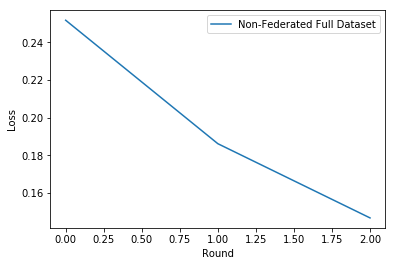

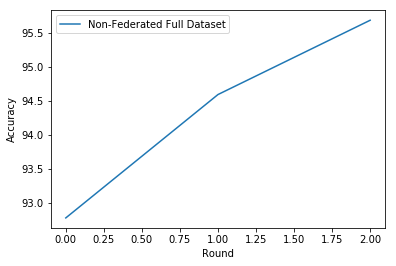

In [8]:
nonfed_mgr = make_manager('Non-Federated Full Dataset', train_dl, test_dset)

run_manager(nonfed_mgr, default_n_rounds, target_acc=default_target_acc)

plot_mgr(nonfed_mgr)

TODO: AND THEN DO WE WANT TO SHOW A SINGLE-WORKER MODEL TRAINED ONLY ON ONE SKEWED DATASET?

This is pretty much what it means to have one model versus the power of a federated model.

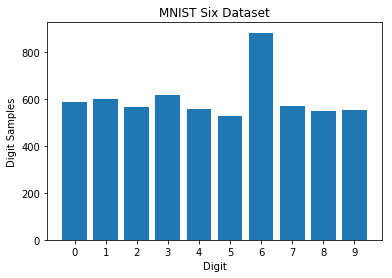

In [9]:
nonfed_six_dl = fm.make_fed_dloaders(train_dset, p=0.15)[6]
plot_digit_histogram([nonfed_six_dl], 'MNIST Six Dataset')

In [10]:
nonfed_six_mgr = make_manager('Non-Federated Sixes Biased 0.15', [nonfed_six_dl], test_dset)
run_manager(nonfed_six_mgr, default_n_rounds, default_target_acc)

Non-Federated Sixes Biased 0.15 manager training with 1 worker(s) for up to 100 rounds or 95.00% accuracy.



Non-Federated Sixes Biased 0.15 manager trained 100 rounds. (Test accuracy 94.75% and loss 0.2285.)


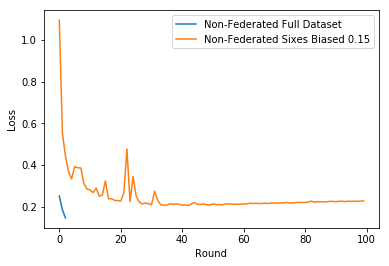

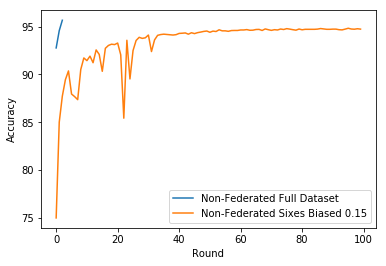

In [11]:
plot_mgr([nonfed_mgr, nonfed_six_mgr])

In [12]:
nonfed_subset_mgr = make_manager('Non-Federated Subset Unbiased', fm.make_fed_dloaders(train_dset, p=0.0)[6], test_dset)
run_manager(nonfed_subset_mgr, default_n_rounds, default_target_acc)

Non-Federated Subset Unbiased manager training with 1 worker(s) for up to 100 rounds or 95.00% accuracy.



Non-Federated Subset Unbiased manager trained 100 rounds. (Test accuracy 94.73% and loss 0.2243.)


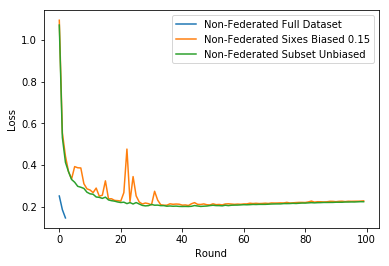

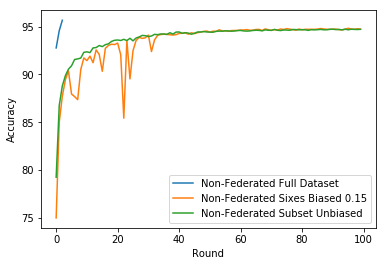

In [13]:
plot_mgr([nonfed_mgr, nonfed_six_mgr, nonfed_subset_mgr])

So it really is the size of the dataset, not the bias, at least at `p`=0.15, that slows and limits accuracy.

# The Federated Approach

Now that we have a baseline using the traditional approach. we train for the same task using federated learning.

## Splitting the Deck Into Piles

To illustrate federated learning we use several workers, each representing a remote device. We'll use ten workers here, and for now, we'll assume each of our ten workers has roughly equal types and quantities of data to the other nine (to do this we set `p` to zero to ).

Our pytorch implementation will create a set of ten training `DataLoader`s, one for each worker (and we we'll leave the test `DataLoader` as it is in the raw MNIST dataset).

In [14]:
fed_equal_dls = fm.make_fed_dloaders(train_dset)

fm.check_dsets([dl.dataset for dl in fed_equal_dls])

Counter({1: 665, 7: 651, 3: 623, 0: 609, 6: 598, 9: 584, 8: 582, 4: 573, 2: 565, 5: 519})
Counter({1: 680, 3: 619, 2: 604, 5: 600, 9: 596, 8: 583, 0: 581, 7: 580, 6: 580, 4: 540})
Counter({3: 638, 0: 638, 1: 631, 6: 604, 7: 587, 2: 575, 8: 574, 9: 573, 5: 547, 4: 539})
Counter({1: 685, 3: 629, 6: 627, 4: 626, 0: 620, 7: 618, 9: 577, 8: 564, 2: 550, 5: 515})
Counter({1: 681, 7: 620, 4: 607, 9: 604, 3: 603, 2: 599, 8: 592, 0: 567, 6: 563, 5: 551})
Counter({1: 688, 7: 682, 3: 673, 0: 609, 8: 601, 2: 592, 4: 580, 6: 575, 5: 570, 9: 556})
Counter({9: 631, 7: 630, 6: 621, 1: 615, 2: 604, 8: 595, 3: 584, 4: 580, 0: 571, 5: 522})
Counter({1: 677, 7: 661, 2: 614, 9: 612, 4: 592, 6: 588, 3: 586, 5: 584, 0: 558, 8: 540})
Counter({1: 738, 3: 642, 2: 641, 4: 622, 7: 617, 9: 615, 6: 585, 0: 581, 8: 577, 5: 492})
Counter({1: 682, 8: 643, 7: 619, 2: 614, 9: 601, 0: 589, 4: 583, 6: 577, 3: 534, 5: 521})


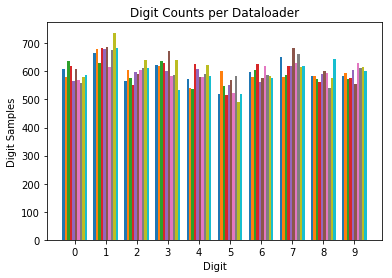

In [15]:
plot_digit_histogram(fed_equal_dls, 'Digit Counts per Dataloader')

So we can see that each of our ten workers has about the same number of each digit, i.e., the digit `5` is spread pretty evenly across the workers, and is probably lower in number for any given worker than the digit `1`, `1` being the most frequent digit in the MNIST set.

In [16]:
fed_equal_mgr = make_manager('Federated Equal', fed_equal_dls, test_dset)

run_manager(fed_equal_mgr, default_n_rounds, default_target_acc)

Federated Equal manager training with 10 worker(s) for up to 100 rounds or 95.00% accuracy.


Federated Equal manager stopped: met accuracy target of 95.00% after 23 rounds. (Test accuracy 95.04% and loss 0.1687.)


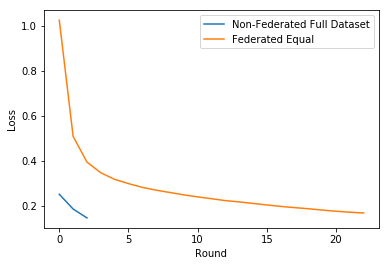

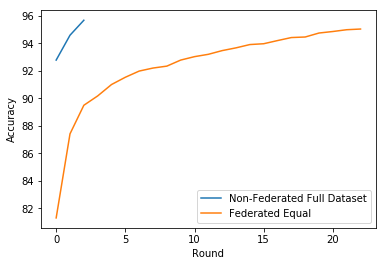

In [17]:
plot_mgr([nonfed_mgr, fed_equal_mgr])

The federated model converges, though a little slower than the non-federated version. But in the federated model, we don't have to move any data to a central system.

# Federation with Varying Example Distributions Per Worker

Now we've seen federation work with a dataset scattered across a number of workers. And we saw that its performance isn't substantially different from the non-federated approach, while decentralizing the work of training and limiting the amount of data transfered between the main manager and the workers.

But what if our workers don't have access to equal amounts of data? Let's explore that.

## Spliting the Decks into Uneven Piles

To test this, we need workers to have access to varying numbers of examples across training classes. So let's make a set of dataloaders that will give each worker more examples of a given digit than the other workers.

The parameter `p` sets the degree of bias toward the overweighted digit in each dataloader. Specifically, `p` is the odds of an example from a specific class being selected for a worker from the base dataset. We'll use `0.15` for `p` for now.

This results in a set of stacked dataloaders. The number of dataloaders is equal to the number of classes. Each dataloader is overweighted to one class.

In [18]:
fed_weighted_dls = fm.make_fed_dloaders(train_dset, p=0.15)

Note that the dataloaders still give each worker roughly the same *total number* of examples. It's the number of examples *per class* that varies.

In [19]:
worker_example_counts = [len(dl.dataset) for dl in fed_weighted_dls]

print(worker_example_counts)

[5948, 6119, 6048, 6159, 5868, 6050, 5895, 5964, 6004, 5945]


And each of the 60,000 examples in the MNIST training dataset is allocated (without replacement) to a worker, so the total number of examples across workers is 60,000.

In [20]:
print(sum(worker_example_counts))

60000


Let's look at how the digit examples are allocated within each worker.

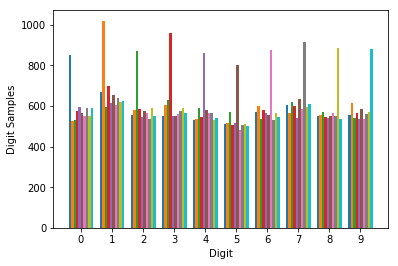

In [21]:
plot_digit_histogram(fed_weighted_dls)

We see here that worker 4, shown in purple, has more examples of the digit `4` than other workers. Likewise, worker 6, shown in pink, has more examples of the digit `6` than other workers.

Here are the actual counts from the dataloaders for workers 4 and 6. You can see that the most frequent examples in those dataloaders are `4` and `6`, respectively.

In [22]:
fm.check_dsets([fed_weighted_dls[4].dataset])

fm.check_dsets([fed_weighted_dls[6].dataset])

Counter({4: 860, 1: 616, 0: 597, 6: 566, 3: 549, 2: 547, 8: 541, 7: 540, 9: 537, 5: 515})
Counter({6: 875, 1: 607, 7: 583, 8: 567, 2: 566, 4: 566, 3: 561, 0: 553, 9: 537, 5: 480})


And if you're curious, here are all of the worker counts.

In [23]:
fm.check_dsets([dl.dataset for dl in fed_weighted_dls])

Counter({0: 851, 1: 667, 7: 604, 6: 570, 9: 556, 2: 554, 8: 551, 3: 549, 4: 533, 5: 513})
Counter({1: 1020, 9: 613, 3: 607, 6: 598, 2: 579, 7: 564, 8: 558, 4: 536, 0: 526, 5: 518})
Counter({2: 873, 3: 628, 7: 620, 1: 596, 4: 589, 8: 570, 5: 568, 9: 540, 6: 535, 0: 529})
Counter({3: 959, 1: 697, 7: 602, 2: 586, 6: 580, 0: 573, 9: 567, 4: 545, 8: 544, 5: 506})
Counter({4: 860, 1: 616, 0: 597, 6: 566, 3: 549, 2: 547, 8: 541, 7: 540, 9: 537, 5: 515})
Counter({5: 801, 1: 652, 7: 633, 9: 587, 4: 578, 2: 577, 0: 566, 6: 555, 3: 551, 8: 550})
Counter({6: 875, 1: 607, 7: 583, 8: 567, 2: 566, 4: 566, 3: 561, 0: 553, 9: 537, 5: 480})
Counter({7: 914, 1: 641, 0: 590, 3: 574, 4: 563, 9: 561, 8: 550, 2: 538, 6: 529, 5: 504})
Counter({8: 886, 1: 619, 7: 595, 2: 589, 3: 588, 9: 569, 6: 565, 0: 550, 4: 530, 5: 513})
Counter({9: 882, 1: 627, 7: 610, 0: 588, 3: 565, 2: 549, 6: 545, 4: 542, 8: 534, 5: 503})


Now let's see how the federated approach performs with variation in the worker datasets.

Fed Bias manager training with 10 worker(s) for up to 100 rounds or 95.00% accuracy.


Fed Bias manager stopped: met accuracy target of 95.00% after 23 rounds. (Test accuracy 95.09% and loss 0.1656.)


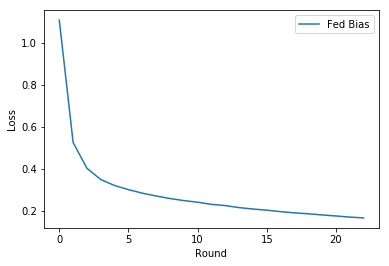

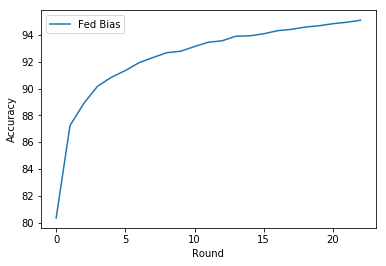

In [24]:
fed_weighted_mgr = make_manager('Fed Bias', fed_weighted_dls, test_dset)
run_manager(fed_weighted_mgr, default_n_rounds, default_target_acc)
plot_mgr(fed_weighted_mgr)

#fed_060_mgr = eval_new_mgr('Fed Bias 0.60', train_dset, test_dset, p=0.60, num_rounds=10, target_acc=None)

#plot_mgr(fed_060_mgr)

The federated model converges just fine.

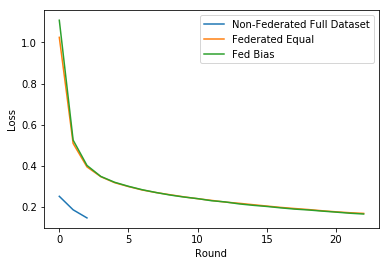

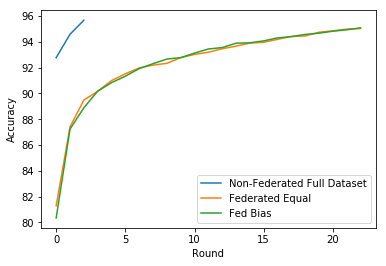

In [25]:
plot_mgr([nonfed_mgr, fed_equal_mgr, fed_weighted_mgr])

Though it converges *just* a little slower than the unbiased federated model.

Let's take a closer look at how performance changes with more-biased data.

Fed Bias 0.0 manager training with 10 worker(s) for up to 10 rounds or 90.00% accuracy.


Fed Bias 0.0 manager stopped: met accuracy target of 90.00% after 4 rounds. (Test accuracy 90.24% and loss 0.3452.)
Fed Bias 0.1 manager training with 10 worker(s) for up to 10 rounds or 90.00% accuracy.


Fed Bias 0.1 manager stopped: met accuracy target of 90.00% after 4 rounds. (Test accuracy 90.28% and loss 0.3509.)
Fed Bias 0.6 manager training with 10 worker(s) for up to 10 rounds or 90.00% accuracy.


Fed Bias 0.6 manager stopped: met accuracy target of 90.00% after 6 rounds. (Test accuracy 90.39% and loss 0.3484.)
Fed Bias 0.9 manager training with 10 worker(s) for up to 10 rounds or 90.00% accuracy.



Fed Bias 0.9 manager trained 10 rounds. (Test accuracy 88.63% and loss 0.4502.)
Fed Bias 0.95 manager training with 10 worker(s) for up to 10 rounds or 90.00% accuracy.



Fed Bias 0.95 manager trained 10 rounds. (Test accuracy 84.71% and loss 0.6535.)
Fed Bias 0.98 manager training with 10 worker(s) for up to 10 rounds or 90.00% accuracy.



Fed Bias 0.98 manager trained 10 rounds. (Test accuracy 80.03% and loss 1.0107.)
Fed Bias 0.999 manager training with 10 worker(s) for up to 10 rounds or 90.00% accuracy.



Fed Bias 0.999 manager trained 10 rounds. (Test accuracy 64.27% and loss 1.7092.)
Fed Bias 1.0 manager training with 10 worker(s) for up to 10 rounds or 90.00% accuracy.



Fed Bias 1.0 manager trained 10 rounds. (Test accuracy 70.66% and loss 1.6978.)



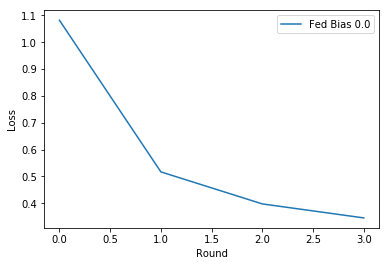

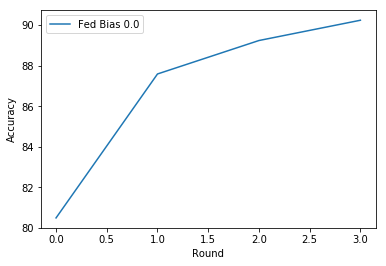

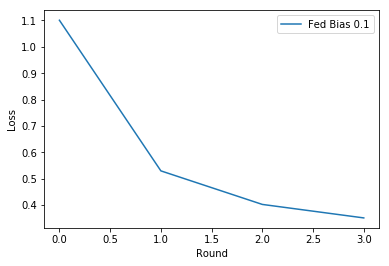

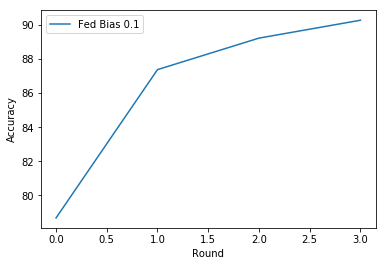

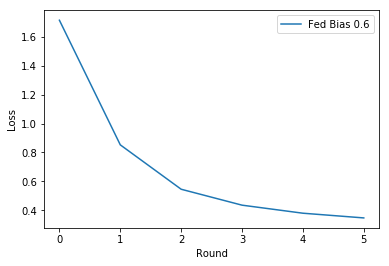

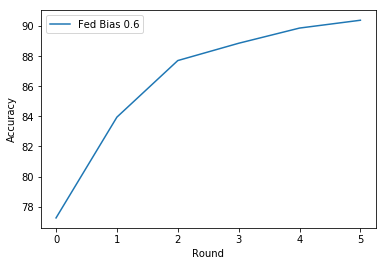

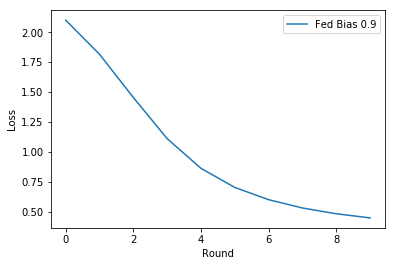

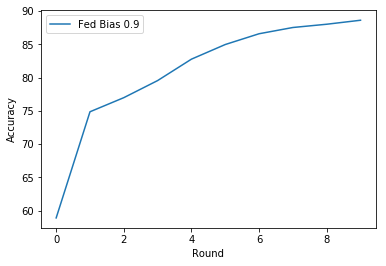

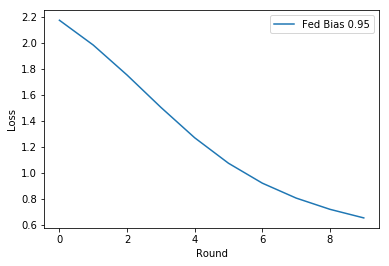

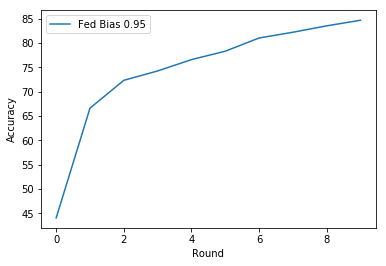

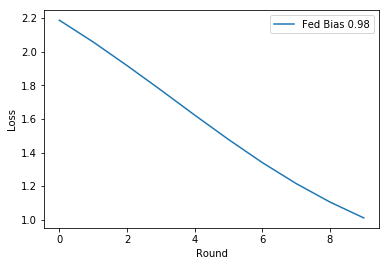

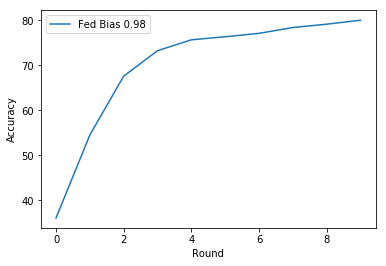

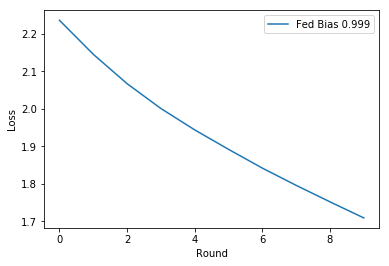

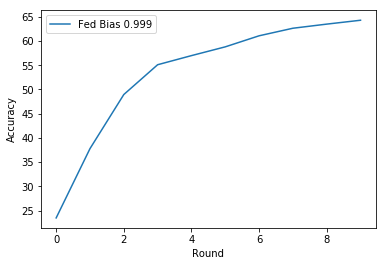

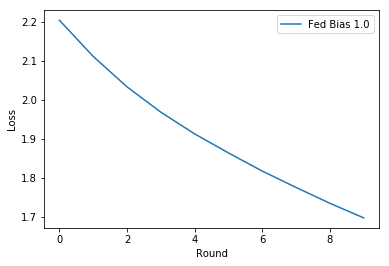

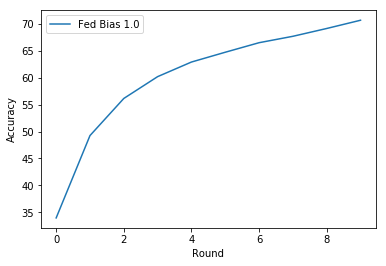

In [26]:
mgrs = [eval_new_mgr(('Fed Bias '+ str(x)), train_dset, test_dset, p=x, n_rounds=10, target_acc=90.0) for x in tqdm([0.0, 0.1, 0.6, 0.9, 0.95, 0.98, 0.999, 1.0])]


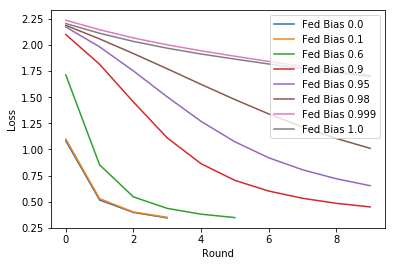

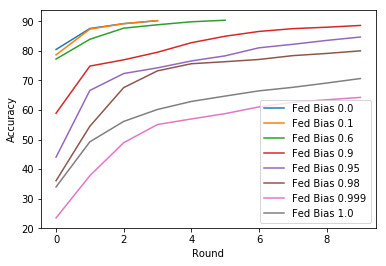

In [27]:
plot_mgr(mgrs)

The federated models converge even with very heavily biased datasets per worker. Unsurprisingly, it takes longer. But even when the datasets are completely biased, that is, each worker sees examples from *exactly one class*.

# EVERYTHING BELOW HERE IS SANDBOX

Fed Bias 0.0 manager training with 10 worker(s) for 100 rounds.



Fed Bias 0.0 manager trained 100 rounds. (Test accuracy 97.89% and loss 0.0696.)
Fed Bias 0.4 manager training with 10 worker(s) for 100 rounds.



Fed Bias 0.4 manager trained 100 rounds. (Test accuracy 97.54% and loss 0.0764.)
Fed Bias 0.6 manager training with 10 worker(s) for 100 rounds.



Fed Bias 0.6 manager trained 100 rounds. (Test accuracy 97.36% and loss 0.0847.)
Fed Bias 0.8 manager training with 10 worker(s) for 100 rounds.



Fed Bias 0.8 manager trained 100 rounds. (Test accuracy 96.38% and loss 0.1146.)
Fed Bias 0.9 manager training with 10 worker(s) for 100 rounds.



Fed Bias 0.9 manager trained 100 rounds. (Test accuracy 95.30% and loss 0.1463.)
Fed Bias 0.95 manager training with 10 worker(s) for 100 rounds.



Fed Bias 0.95 manager trained 100 rounds. (Test accuracy 94.04% and loss 0.2073.)
Fed Bias 0.98 manager training with 10 worker(s) for 100 rounds.



Fed Bias 0.98 manager trained 100 rounds. (Test accuracy 91.48% and loss 0.2842.)
Fed Bias 0.99 manager training with 10 worker(s) for 100 rounds.



Fed Bias 0.99 manager trained 100 rounds. (Test accuracy 89.64% and loss 0.3444.)
Fed Bias 1.0 manager training with 10 worker(s) for 100 rounds.



Fed Bias 1.0 manager trained 100 rounds. (Test accuracy 81.31% and loss 0.6233.)



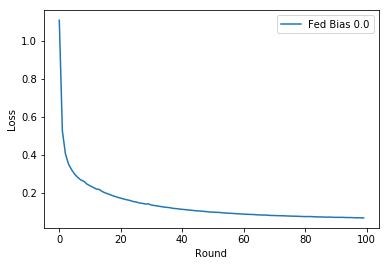

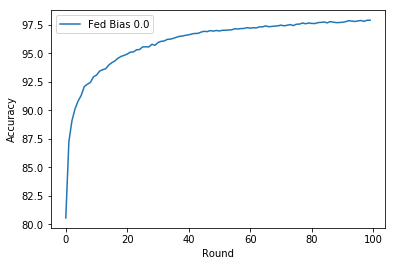

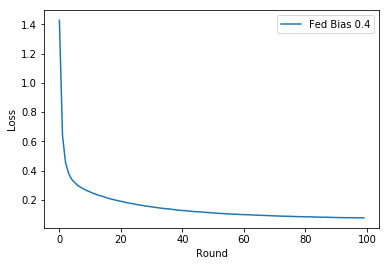

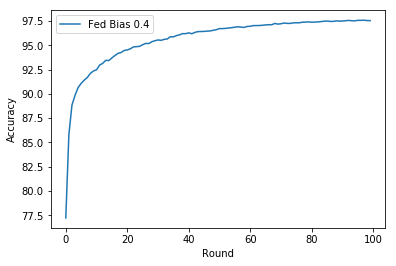

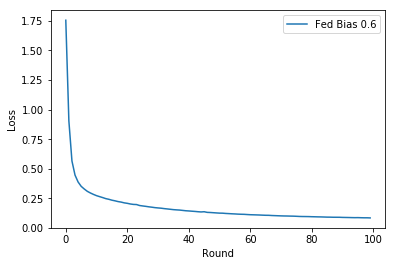

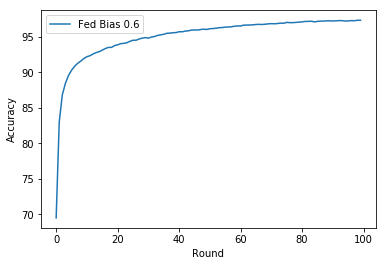

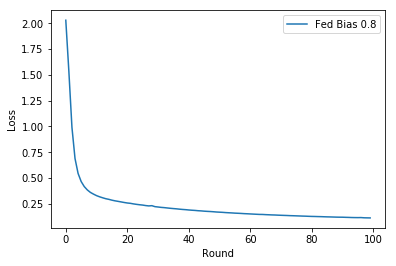

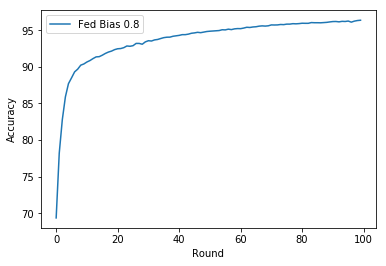

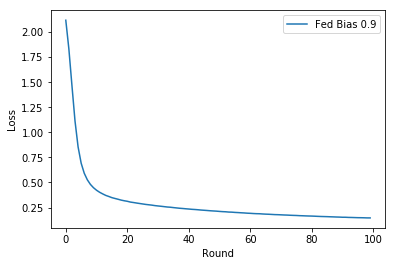

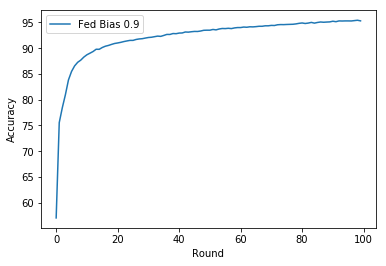

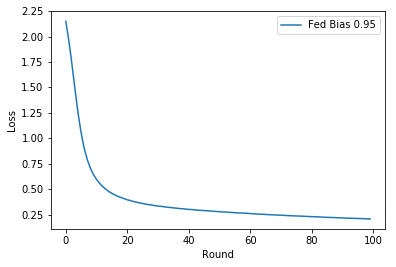

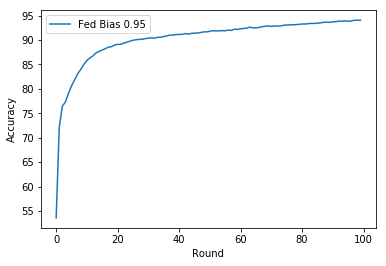

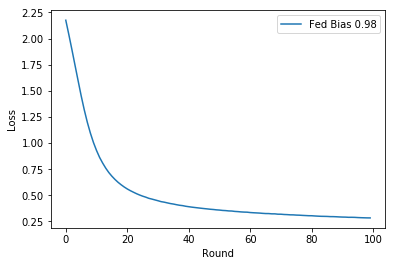

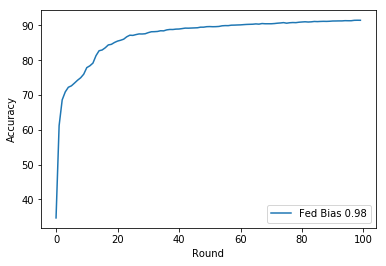

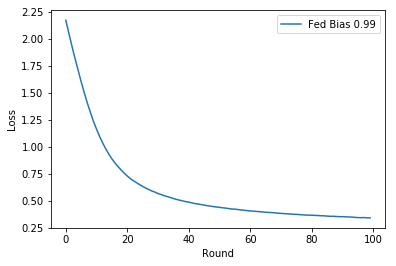

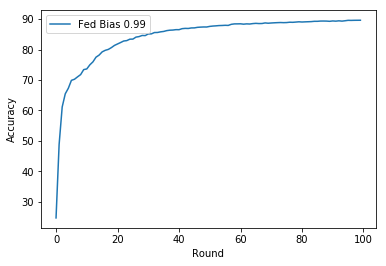

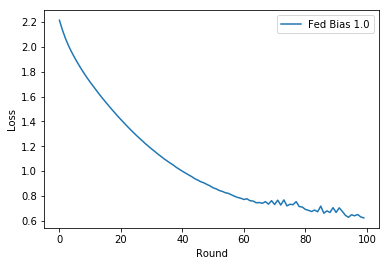

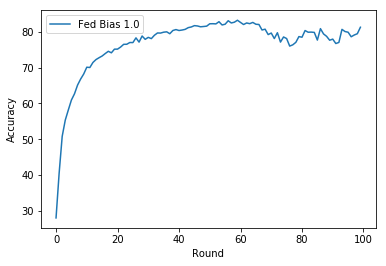

In [59]:
mgrs2 = [eval_new_mgr(('Fed Bias '+ str(x)), train_dset, test_dset, p=x, n_rounds=100, target_acc=None) for x in tqdm([0.0, 0.4, 0.6, 0.8, 0.9, 0.95, 0.98, 0.99, 1.0])]

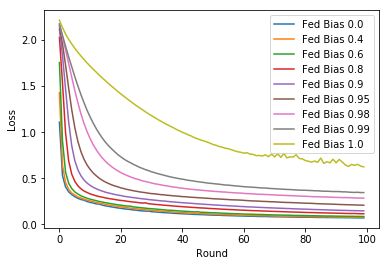

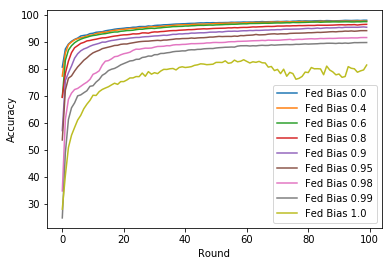

In [60]:
plot_mgr(mgrs2)

Fed Bias 0.0 manager training with 10 worker(s) for 300 rounds.



Fed Bias 0.0 manager trained 300 rounds. (Test accuracy 98.18% and loss 0.0649.)
Fed Bias 0.4 manager training with 10 worker(s) for 300 rounds.



Fed Bias 0.4 manager trained 300 rounds. (Test accuracy 98.11% and loss 0.0639.)
Fed Bias 0.6 manager training with 10 worker(s) for 300 rounds.



Fed Bias 0.6 manager trained 300 rounds. (Test accuracy 97.97% and loss 0.0712.)
Fed Bias 0.8 manager training with 10 worker(s) for 300 rounds.



Fed Bias 0.8 manager trained 300 rounds. (Test accuracy 97.30% and loss 0.0849.)
Fed Bias 0.9 manager training with 10 worker(s) for 300 rounds.



Fed Bias 0.9 manager trained 300 rounds. (Test accuracy 96.84% and loss 0.1011.)
Fed Bias 0.95 manager training with 10 worker(s) for 300 rounds.


KeyboardInterrupt: 

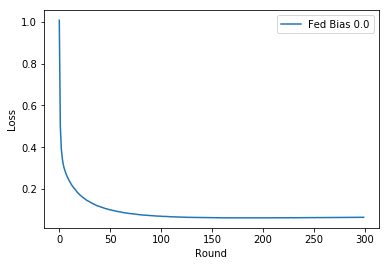

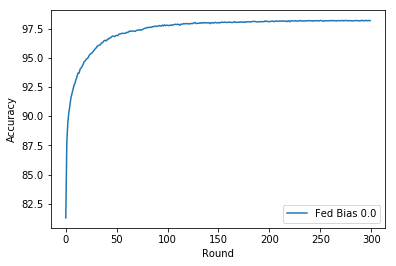

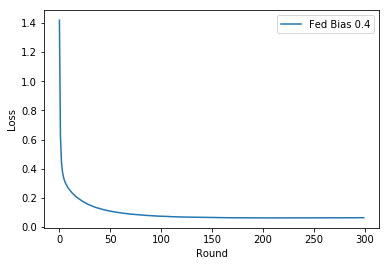

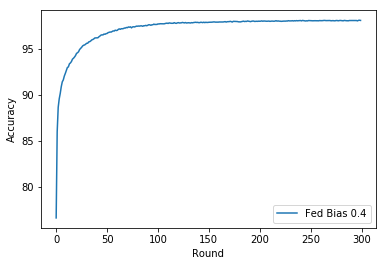

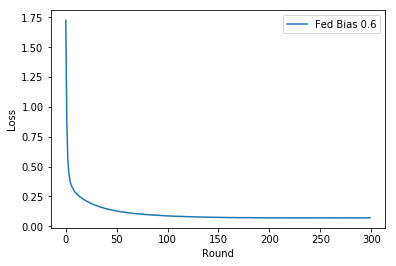

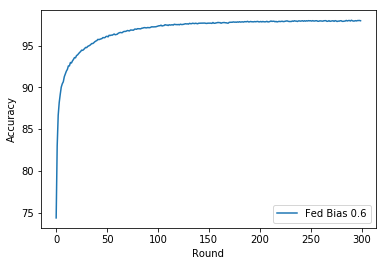

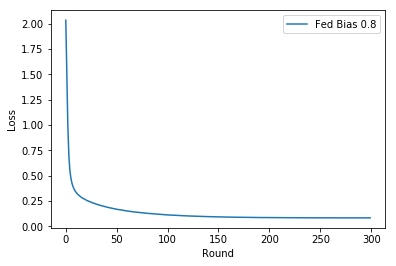

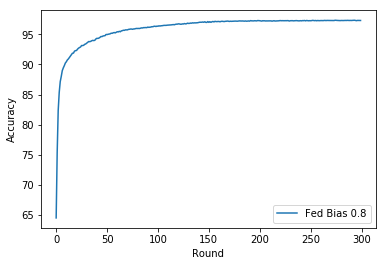

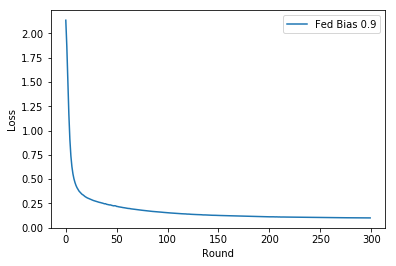

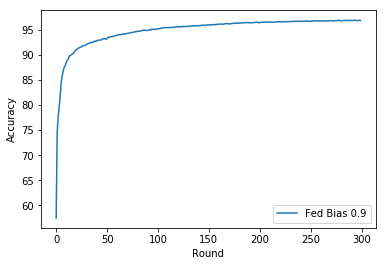

In [61]:
mgrs3 = [eval_new_mgr(('Fed Bias '+ str(x)), train_dset, test_dset, p=x, n_rounds=300, target_acc=None) for x in tqdm([0.0, 0.4, 0.6, 0.8, 0.9, 0.95, 0.98, 0.99, 1.0])]

In [ ]:
plot_mgr(mgrs3)

Fed Bias 0.9 manager training with 10 worker(s) for 300 rounds.



Fed Bias 0.9 manager trained 300 rounds. (Test accuracy 96.96% and loss 0.0935.)
Fed Bias 0.95 manager training with 10 worker(s) for 300 rounds.



Fed Bias 0.95 manager trained 300 rounds. (Test accuracy 96.15% and loss 0.1242.)
Fed Bias 0.98 manager training with 10 worker(s) for 300 rounds.



Fed Bias 0.98 manager trained 300 rounds. (Test accuracy 94.43% and loss 0.1800.)
Fed Bias 0.99 manager training with 10 worker(s) for 300 rounds.



Fed Bias 0.99 manager trained 300 rounds. (Test accuracy 92.64% and loss 0.2305.)
Fed Bias 0.992 manager training with 10 worker(s) for 300 rounds.



Fed Bias 0.992 manager trained 300 rounds. (Test accuracy 92.26% and loss 0.2439.)
Fed Bias 0.995 manager training with 10 worker(s) for 300 rounds.



Fed Bias 0.995 manager trained 300 rounds. (Test accuracy 91.29% and loss 0.2726.)
Fed Bias 0.997 manager training with 10 worker(s) for 300 rounds.



Fed Bias 0.997 manager trained 300 rounds. (Test accuracy 91.04% and loss 0.2962.)
Fed Bias 0.999 manager training with 10 worker(s) for 300 rounds.



Fed Bias 0.999 manager trained 300 rounds. (Test accuracy 89.32% and loss 0.3400.)
Fed Bias 1.0 manager training with 10 worker(s) for 300 rounds.



Fed Bias 1.0 manager trained 300 rounds. (Test accuracy 87.14% and loss 0.4144.)



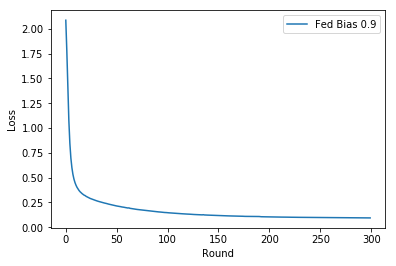

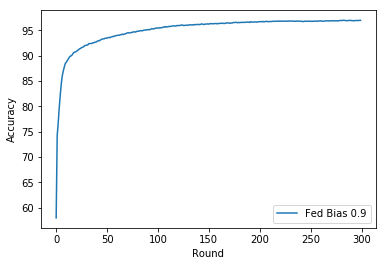

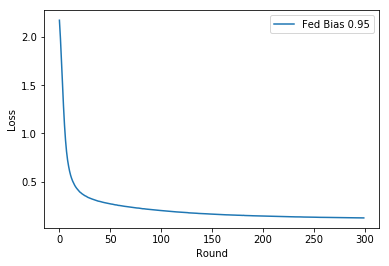

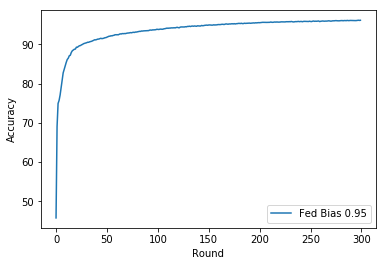

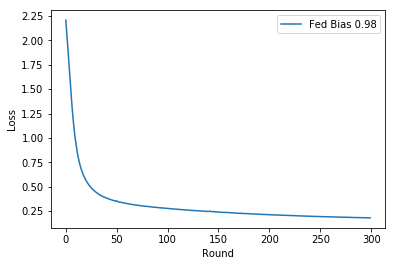

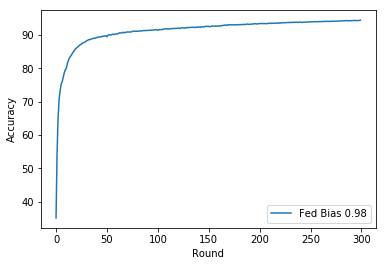

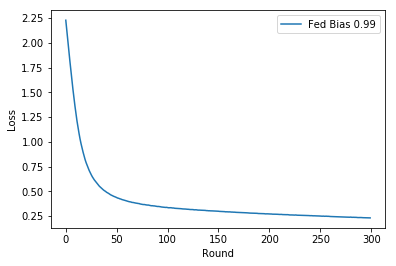

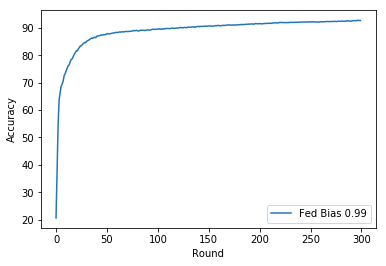

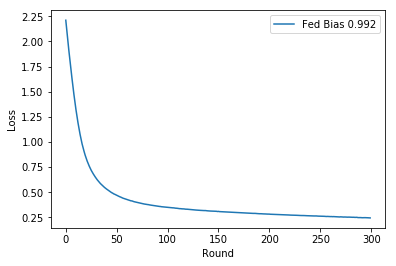

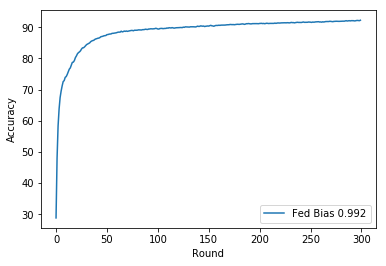

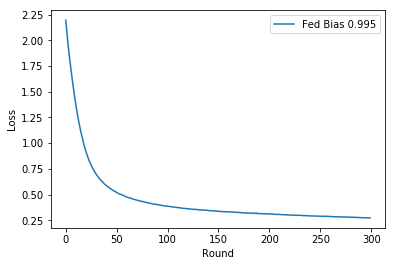

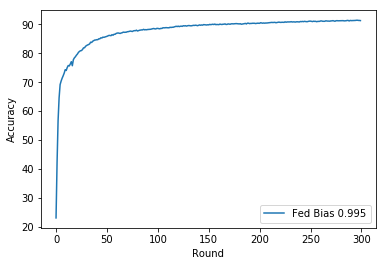

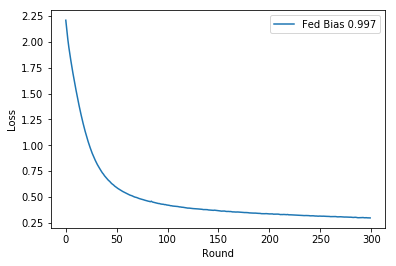

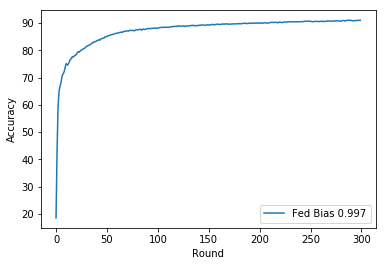

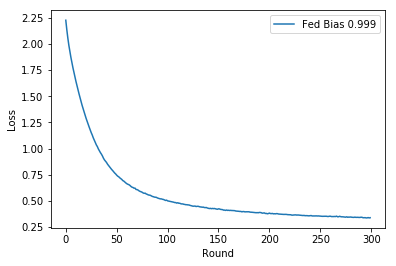

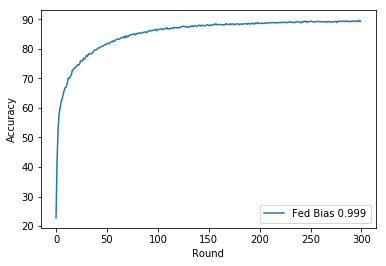

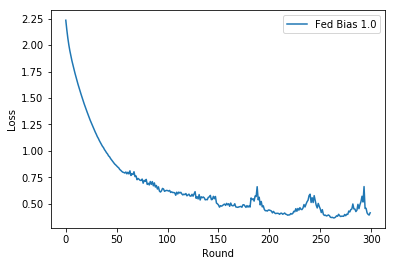

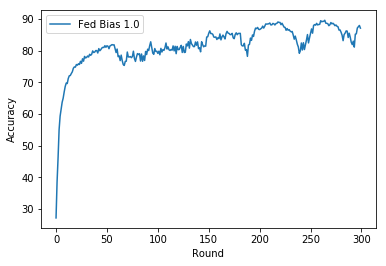

In [57]:
mgrs4 = [eval_new_mgr(('Fed Bias '+ str(x)), train_dset, test_dset, p=x, n_rounds=300, target_acc=None) for x in tqdm([0.9, 0.95, 0.98, 0.99, 0.992, 0.995, 0.997, 0.999, 1.0])]

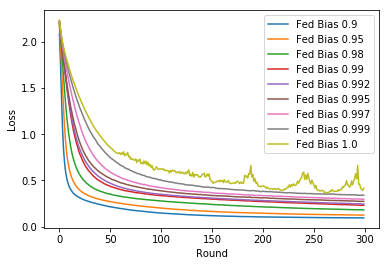

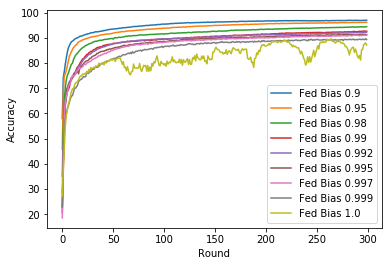

In [58]:
plot_mgr(mgrs4)

In [ ]:
# find the number of rounds to hit the target accuracy

def rounds_to_target(mgrs, target_acc = 95.0):
    for m in mgrs:
        target_met = False
        for i in range(len(m.history['test_acc'])):
            if m.history['test_acc'][i] >= target_acc:
                print(m.name, 'manager met target', target_acc, '% accuracy: ', m.history['test_acc'][i], '% after round', i)
                target_met = True
                break;
        if not target_met:
            print(m.name, 'manager did not meet target', target_acc, '% accuracy. Reached', m.history['test_acc'][-1], '% after round', len(m.history['test_acc'])-1)
            
rounds_to_target(mgrs3, 95.0)

In [ ]:
# Need to parameterize this better

def eval_stacks(biases, target_acc):
    
    mgrs = []
    
    for b in tqdm(biases, desc='building datasets'):
        stacked_dsets = fm.make_fed_dsets(train_dset, p=b)
        fm.check_dsets(stacked_dsets)

        stk_mgr = federated.FederatedManager(
            [DataLoader(dset, batch_size=train_batch_size, shuffle=True)
                                for dset in stacked_dsets],
            Net,
            nn.CrossEntropyLoss(),
            test_dset,
            num_epochs,
            learning_rate,
            verbose
        )
        mgrs.append(stk_mgr)
        
    for mgr in tqdm(mgrs, desc='evaluating managers'):
        run_manager(mgr, num_rounds)

    plot_loss(mgrs)
    plot_acc(mgrs)
    rounds_to_target(mgrs)

In [ ]:
#eval_stacks([0.0, 0.1, 0.2, 0.4, 0.8, 0.9, 0.95, 0.98, 1.0], 95.0)

In [ ]:
#eval_stacks([0.0, 0.1, 0.99, 0.999, 1.0], 95.0)

In [31]:
full_bias_dls = fm.make_fed_dloaders(train_dset, p=1.0)

In [32]:
fm.check_dsets([dl.dataset for dl in full_bias_dls])

Counter({0: 5923})
Counter({1: 6742})
Counter({2: 5958})
Counter({3: 6131})
Counter({4: 5842})
Counter({5: 5421})
Counter({6: 5918})
Counter({7: 6265})
Counter({8: 5851})
Counter({9: 5949})


In [35]:
fm.check_dsets([dl.dataset for dl in fm.make_fed_dloaders(train_dset, p=0.995)])

Counter({0: 5882, 9: 8, 7: 8, 5: 7, 3: 3, 6: 3, 2: 3, 8: 1, 1: 1})
Counter({1: 6709, 7: 6, 0: 5, 9: 4, 2: 4, 3: 2, 5: 2, 6: 2, 4: 1, 8: 1})
Counter({2: 5927, 4: 5, 0: 4, 7: 4, 8: 4, 5: 4, 9: 2, 1: 2, 6: 1})
Counter({3: 6116, 1: 6, 0: 4, 2: 4, 6: 3, 4: 2, 5: 2, 7: 2, 9: 1, 8: 1})
Counter({4: 5828, 0: 7, 9: 5, 7: 5, 8: 4, 1: 4, 5: 3, 2: 2, 3: 1, 6: 1})
Counter({5: 5392, 8: 6, 1: 5, 2: 4, 3: 3, 7: 2, 6: 2, 4: 1, 9: 1})
Counter({6: 5889, 8: 5, 0: 5, 2: 3, 9: 3, 4: 3, 1: 2, 7: 2, 3: 1, 5: 1})
Counter({7: 6234, 6: 6, 1: 4, 8: 3, 9: 3, 0: 3, 3: 2, 5: 2, 2: 2})
Counter({8: 5824, 1: 8, 6: 5, 0: 5, 9: 4, 5: 4, 2: 3, 3: 3, 7: 1})
Counter({9: 5918, 0: 8, 6: 6, 2: 6, 5: 4, 8: 2, 4: 2, 1: 1, 7: 1})


In [46]:
fm.check_dsets([dl.dataset for dl in fm.make_fed_dloaders(train_dset, p=0.995)])

Counter({0: 5901, 2: 7, 8: 5, 1: 4, 7: 4, 3: 4, 4: 3, 9: 3, 5: 2, 6: 2})
Counter({1: 6705, 6: 7, 5: 7, 3: 4, 9: 3, 2: 3, 4: 3, 0: 2, 7: 2, 8: 2})
Counter({2: 5929, 6: 6, 9: 6, 1: 4, 7: 3, 4: 3, 5: 3, 0: 2, 3: 2})
Counter({3: 6107, 8: 7, 4: 6, 2: 6, 1: 6, 7: 4, 0: 4, 5: 2, 9: 2, 6: 1})
Counter({4: 5811, 6: 5, 9: 5, 3: 4, 7: 3, 1: 3, 0: 3, 8: 1, 2: 1, 5: 1})
Counter({5: 5397, 4: 5, 1: 4, 6: 4, 2: 4, 7: 4, 3: 3, 9: 2, 0: 2, 8: 1})
Counter({6: 5885, 2: 4, 0: 4, 3: 3, 9: 3, 8: 3, 5: 3, 4: 2})
Counter({7: 6238, 9: 5, 1: 5, 2: 4, 4: 3, 8: 3, 5: 2, 0: 2, 6: 1})
Counter({8: 5826, 4: 4, 7: 3, 1: 3, 6: 3, 3: 2, 5: 2, 0: 1, 9: 1})
Counter({9: 5919, 1: 8, 7: 4, 6: 4, 8: 3, 4: 2, 0: 2, 3: 2, 5: 2})


In [45]:
fm.check_dsets([dl.dataset for dl in fm.make_fed_dloaders(train_dset, p=0.995)])

Counter({0: 5888, 8: 10, 5: 5, 4: 5, 3: 4, 2: 3, 7: 2, 6: 2, 9: 1, 1: 1})
Counter({1: 6717, 4: 6, 6: 5, 3: 5, 7: 5, 9: 3, 5: 2, 8: 2, 0: 1})
Counter({2: 5929, 7: 7, 0: 4, 6: 4, 4: 3, 9: 3, 5: 2, 1: 2, 8: 2, 3: 1})
Counter({3: 6106, 2: 6, 9: 6, 8: 5, 6: 3, 5: 3, 7: 2, 0: 2, 4: 2, 1: 2})
Counter({4: 5813, 7: 8, 9: 5, 3: 4, 1: 4, 6: 3, 2: 3, 5: 2, 0: 2, 8: 2})
Counter({5: 5399, 4: 6, 8: 6, 9: 5, 1: 5, 7: 5, 2: 4, 3: 2, 0: 2, 6: 1})
Counter({6: 5892, 0: 9, 2: 5, 3: 3, 9: 2, 1: 2, 7: 2, 8: 2, 4: 1, 5: 1})
Counter({7: 6221, 1: 3, 4: 3, 3: 2, 0: 2, 8: 2, 6: 2, 9: 1, 2: 1})
Counter({8: 5820, 7: 10, 0: 9, 5: 4, 6: 3, 2: 3, 1: 3, 4: 2, 9: 2, 3: 2})
Counter({9: 5921, 0: 4, 2: 4, 5: 3, 7: 3, 6: 3, 1: 3, 3: 2, 4: 1})


In [44]:
fm.check_dsets([dl.dataset for dl in fm.make_fed_dloaders(train_dset, p=0.996)])

Counter({0: 5900, 6: 4, 2: 4, 7: 4, 3: 4, 8: 3, 5: 3, 1: 3, 9: 1})
Counter({1: 6716, 3: 7, 9: 5, 6: 4, 7: 4, 2: 3, 5: 2, 4: 2, 8: 1})
Counter({2: 5931, 7: 5, 8: 4, 1: 4, 0: 3, 3: 3, 6: 2, 5: 2, 9: 2, 4: 1})
Counter({3: 6091, 8: 6, 0: 4, 1: 4, 7: 3, 9: 3, 5: 3, 6: 2, 4: 2, 2: 1})
Counter({4: 5829, 3: 9, 1: 5, 2: 4, 5: 4, 7: 3, 6: 3, 9: 3, 0: 3, 8: 1})
Counter({5: 5398, 7: 6, 8: 3, 6: 2, 4: 2, 3: 2, 2: 2, 9: 1, 0: 1})
Counter({6: 5893, 1: 5, 0: 5, 8: 4, 2: 4, 3: 3, 9: 3, 5: 2, 4: 2, 7: 2})
Counter({7: 6234, 3: 4, 6: 4, 2: 2, 0: 2, 9: 2, 8: 1, 4: 1, 5: 1})
Counter({8: 5826, 3: 3, 9: 3, 1: 3, 5: 2, 4: 2, 0: 2, 7: 2, 6: 1, 2: 1})
Counter({9: 5926, 2: 6, 3: 5, 5: 4, 0: 3, 6: 3, 7: 2, 1: 2, 8: 2, 4: 1})


In [41]:
fm.check_dsets([dl.dataset for dl in fm.make_fed_dloaders(train_dset, p=0.997)])

Counter({0: 5900, 1: 7, 3: 3, 2: 3, 8: 3, 5: 2, 9: 2, 7: 2, 6: 1})
Counter({1: 6721, 2: 7, 3: 6, 8: 4, 5: 2, 0: 2, 4: 2, 9: 1, 6: 1})
Counter({2: 5935, 7: 5, 3: 4, 9: 3, 0: 3, 1: 3, 4: 2, 6: 1, 5: 1})
Counter({3: 6101, 6: 5, 4: 4, 9: 3, 5: 3, 0: 1, 8: 1, 7: 1})
Counter({4: 5821, 5: 4, 9: 3, 1: 3, 3: 3, 0: 2, 8: 2, 2: 2, 6: 1})
Counter({5: 5402, 4: 7, 7: 5, 1: 3, 0: 3, 9: 2, 3: 2, 6: 1, 2: 1})
Counter({6: 5904, 8: 4, 2: 3, 3: 3, 9: 2, 0: 2, 5: 1, 7: 1})
Counter({7: 6248, 2: 5, 0: 3, 8: 2, 6: 2, 3: 2, 4: 2, 1: 1, 9: 1, 5: 1})
Counter({8: 5832, 4: 4, 0: 3, 3: 2, 1: 1, 6: 1, 2: 1, 5: 1, 7: 1})
Counter({9: 5932, 3: 5, 0: 4, 5: 4, 8: 3, 1: 3, 7: 2, 6: 1, 2: 1})


In [40]:
fm.check_dsets([dl.dataset for dl in fm.make_fed_dloaders(train_dset, p=0.998)])

Counter({0: 5910, 9: 2, 3: 1, 6: 1, 8: 1, 1: 1})
Counter({1: 6728, 6: 2, 9: 1, 4: 1, 2: 1, 0: 1})
Counter({2: 5949, 8: 2, 0: 2, 3: 2, 7: 2, 5: 1, 9: 1, 1: 1, 6: 1, 4: 1})
Counter({3: 6120, 9: 5, 2: 4, 5: 2, 0: 2, 1: 2, 8: 2, 4: 1, 7: 1})
Counter({4: 5833, 6: 3, 3: 3, 7: 2, 1: 1, 5: 1, 0: 1})
Counter({5: 5413, 3: 3, 7: 2, 4: 1, 1: 1, 8: 1})
Counter({6: 5906, 7: 3, 5: 3, 8: 2, 9: 2, 1: 2, 0: 1})
Counter({7: 6248, 1: 4, 2: 3, 4: 2, 0: 2, 3: 2, 8: 1, 6: 1, 9: 1})
Counter({8: 5842, 1: 2, 7: 2, 0: 2, 9: 1, 4: 1, 6: 1, 5: 1})
Counter({9: 5936, 7: 5, 6: 3, 4: 2, 0: 2, 2: 1})


In [55]:
fm.check_dsets([dl.dataset for dl in fm.make_fed_dloaders(train_dset, p=0.9992)])

Counter({0: 5914, 6: 2, 7: 1, 2: 1, 1: 1})
Counter({1: 6735, 0: 3, 6: 2, 5: 1})
Counter({2: 5956, 5: 3})
Counter({3: 6129, 6: 2, 7: 2, 5: 1, 4: 1})
Counter({4: 5838, 6: 1, 5: 1, 1: 1, 0: 1, 9: 1, 8: 1})
Counter({5: 5412, 6: 1, 2: 1, 0: 1, 9: 1})
Counter({6: 5909, 9: 3, 8: 2, 1: 2, 5: 2, 7: 1, 4: 1})
Counter({7: 6259, 0: 2, 8: 1, 6: 1, 1: 1})
Counter({8: 5846, 7: 2, 0: 1, 4: 1})
Counter({9: 5944, 1: 2, 3: 2, 4: 1, 5: 1, 8: 1, 0: 1})


In [54]:
fm.check_dsets([dl.dataset for dl in fm.make_fed_dloaders(train_dset, p=0.9992)])

Counter({0: 5917, 8: 2, 5: 1, 3: 1})
Counter({1: 6740, 3: 2})
Counter({2: 5954, 0: 2, 9: 1, 3: 1, 7: 1})
Counter({3: 6124, 7: 2, 8: 1, 9: 1, 0: 1})
Counter({4: 5841, 8: 2, 0: 2, 2: 1, 6: 1})
Counter({5: 5420, 9: 3, 7: 1, 2: 1})
Counter({6: 5916, 3: 1, 8: 1, 2: 1, 7: 1, 1: 1, 4: 1})
Counter({7: 6260, 1: 1, 2: 1})
Counter({8: 5845, 6: 1, 0: 1})
Counter({9: 5944, 3: 2})


In [53]:
fm.check_dsets([dl.dataset for dl in fm.make_fed_dloaders(train_dset, p=0.9992)])

Counter({0: 5916, 4: 2, 9: 1})
Counter({1: 6736, 2: 1, 0: 1, 9: 1})
Counter({2: 5953, 5: 2, 9: 2, 3: 1, 0: 1, 4: 1, 6: 1})
Counter({3: 6129, 1: 3, 7: 1, 2: 1, 6: 1, 9: 1, 0: 1})
Counter({4: 5838, 7: 4, 8: 2, 9: 1, 1: 1, 2: 1})
Counter({5: 5418, 2: 1, 7: 1, 1: 1, 4: 1, 3: 1})
Counter({6: 5914, 0: 1, 7: 1})
Counter({7: 6256, 0: 2, 6: 1})
Counter({8: 5848, 0: 1, 7: 1, 1: 1})
Counter({9: 5943, 7: 1, 8: 1, 5: 1, 2: 1, 6: 1})


In [47]:
fm.check_dsets([dl.dataset for dl in fm.make_fed_dloaders(train_dset, p=0.9995)])

Counter({0: 5922})
Counter({1: 6738, 6: 2, 2: 2, 7: 1, 9: 1})
Counter({2: 5952, 5: 1, 1: 1, 8: 1})
Counter({3: 6127, 6: 1, 7: 1})
Counter({4: 5839, 6: 2, 8: 1, 2: 1, 1: 1, 3: 1})
Counter({5: 5418, 3: 2, 7: 1, 4: 1})
Counter({6: 5910, 8: 2, 3: 1, 2: 1})
Counter({7: 6260, 2: 2, 6: 2, 8: 1, 9: 1, 4: 1})
Counter({8: 5846, 6: 1, 1: 1, 0: 1, 9: 1, 5: 1, 4: 1})
Counter({9: 5946, 7: 2, 5: 1, 1: 1})


In [48]:
fm.check_dsets([dl.dataset for dl in fm.make_fed_dloaders(train_dset, p=0.9997)])

Counter({0: 5921, 6: 1})
Counter({1: 6742, 4: 2, 6: 1})
Counter({2: 5958, 9: 1})
Counter({3: 6131, 9: 1})
Counter({4: 5836, 9: 1})
Counter({5: 5420})
Counter({6: 5913, 9: 2, 0: 1, 5: 1})
Counter({7: 6265, 4: 2, 8: 1, 6: 1})
Counter({8: 5850, 4: 1, 9: 1})
Counter({9: 5943, 6: 2, 4: 1, 0: 1})


In [49]:
fm.check_dsets([dl.dataset for dl in fm.make_fed_dloaders(train_dset, p=0.9998)])

Counter({0: 5923, 5: 1})
Counter({1: 6741, 5: 1})
Counter({2: 5958, 4: 2})
Counter({3: 6129, 8: 1, 4: 1})
Counter({4: 5838, 9: 1})
Counter({5: 5418, 3: 2, 9: 1, 7: 1})
Counter({6: 5917, 1: 1})
Counter({7: 6264, 5: 1, 6: 1, 4: 1})
Counter({8: 5850})
Counter({9: 5947})


In [56]:
fm.check_dsets([dl.dataset for dl in fm.make_fed_dloaders(train_dset, p=0.9999)])

Counter({0: 5922})
Counter({1: 6740, 0: 1, 9: 1})
Counter({2: 5958})
Counter({3: 6131})
Counter({4: 5842, 7: 1, 1: 1})
Counter({5: 5421, 1: 1})
Counter({6: 5918})
Counter({7: 6264})
Counter({8: 5851})
Counter({9: 5948})


In [42]:
fm.check_dsets([dl.dataset for dl in fm.make_fed_dloaders(train_dset, p=1.0)])

Counter({0: 5923})
Counter({1: 6742})
Counter({2: 5958})
Counter({3: 6131})
Counter({4: 5842})
Counter({5: 5421})
Counter({6: 5918})
Counter({7: 6265})
Counter({8: 5851})
Counter({9: 5949})


In [50]:
fm.check_dsets([dl.dataset for dl in fm.make_fed_dloaders(train_dset, p=1.0)])

Counter({0: 5923})
Counter({1: 6742})
Counter({2: 5958})
Counter({3: 6131})
Counter({4: 5842})
Counter({5: 5421})
Counter({6: 5918})
Counter({7: 6265})
Counter({8: 5851})
Counter({9: 5949})


In [51]:
fm.check_dsets([dl.dataset for dl in fm.make_fed_dloaders(train_dset, p=1.0)])

Counter({0: 5923})
Counter({1: 6742})
Counter({2: 5958})
Counter({3: 6131})
Counter({4: 5842})
Counter({5: 5421})
Counter({6: 5918})
Counter({7: 6265})
Counter({8: 5851})
Counter({9: 5949})


In [52]:
fm.check_dsets([dl.dataset for dl in fm.make_fed_dloaders(train_dset, p=1.0)])

Counter({0: 5923})
Counter({1: 6742})
Counter({2: 5958})
Counter({3: 6131})
Counter({4: 5842})
Counter({5: 5421})
Counter({6: 5918})
Counter({7: 6265})
Counter({8: 5851})
Counter({9: 5949})


# Conclusion
TODO: WRAP UP THE BLOG POST HERE. EVERYTHING BELOW IS PART TWO OR THREE

In [1]:
import json

json_test_dump = json.dumps(fed_weighted_mgr.__dict__)
print(json_test_dump)

NameError: name 'fed_weighted_mgr' is not defined

TODO? Persist parameters, histories, results for every run. JSON?

Create a skewing function that allows skewing multiple variables.

How does performance change if we have high-entropy class corellation? Put 1s and 7s together and 3s and 8s. Does this help more than 1s and 8s and 7s and 3s?